In [629]:
import numpy as np
import pandas as pd
import random
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


df1 = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df2 = pd.read_csv('student_sleep_patterns.csv')
rows_to_drop = random.sample(range(df2.shape[0]), 450)
df2 = df2.drop(index=rows_to_drop).reset_index(drop=True)
columns_mapping = {
    'Sleep Duration': 'Sleep_Duration',
    'Quality of Sleep': 'Sleep_Quality',
    'Physical Activity Level': 'Physical_Activity',
}

df1 = df1.rename(columns=columns_mapping).filter(['Age', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity'])
df2 = df2.rename(columns=columns_mapping).filter(['Age', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity'])

merged_df = pd.concat([df1, df2], ignore_index=True)


print(merged_df.isnull().sum())
print(merged_df.head())
print(merged_df.describe())

Age                  0
Sleep_Duration       0
Sleep_Quality        0
Physical_Activity    0
dtype: int64
   Age  Sleep_Duration  Sleep_Quality  Physical_Activity
0   27             6.1              6                 42
1   28             6.2              6                 60
2   28             6.2              6                 60
3   28             5.9              4                 30
4   28             5.9              4                 30
              Age  Sleep_Duration  Sleep_Quality  Physical_Activity
count  424.000000      424.000000     424.000000         424.000000
mean    39.759434        7.054481       7.101415          59.216981
std     10.536379        0.912316       1.583484          23.830074
min     18.000000        4.200000       1.000000           3.000000
25%     32.000000        6.300000       6.000000          45.000000
50%     40.000000        7.200000       7.000000          60.000000
75%     49.000000        7.800000       8.000000          75.000000
max     5

In [630]:
print("Missing Values Before Imputation:\n", merged_df.isnull().sum())
imputer = SimpleImputer(strategy='mean') 
merged_df[['Age', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity']] = imputer.fit_transform(
    merged_df[['Age', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity']]
)
print("Missing Values After Imputation:\n", merged_df.isnull().sum())

Missing Values Before Imputation:
 Age                  0
Sleep_Duration       0
Sleep_Quality        0
Physical_Activity    0
dtype: int64
Missing Values After Imputation:
 Age                  0
Sleep_Duration       0
Sleep_Quality        0
Physical_Activity    0
dtype: int64


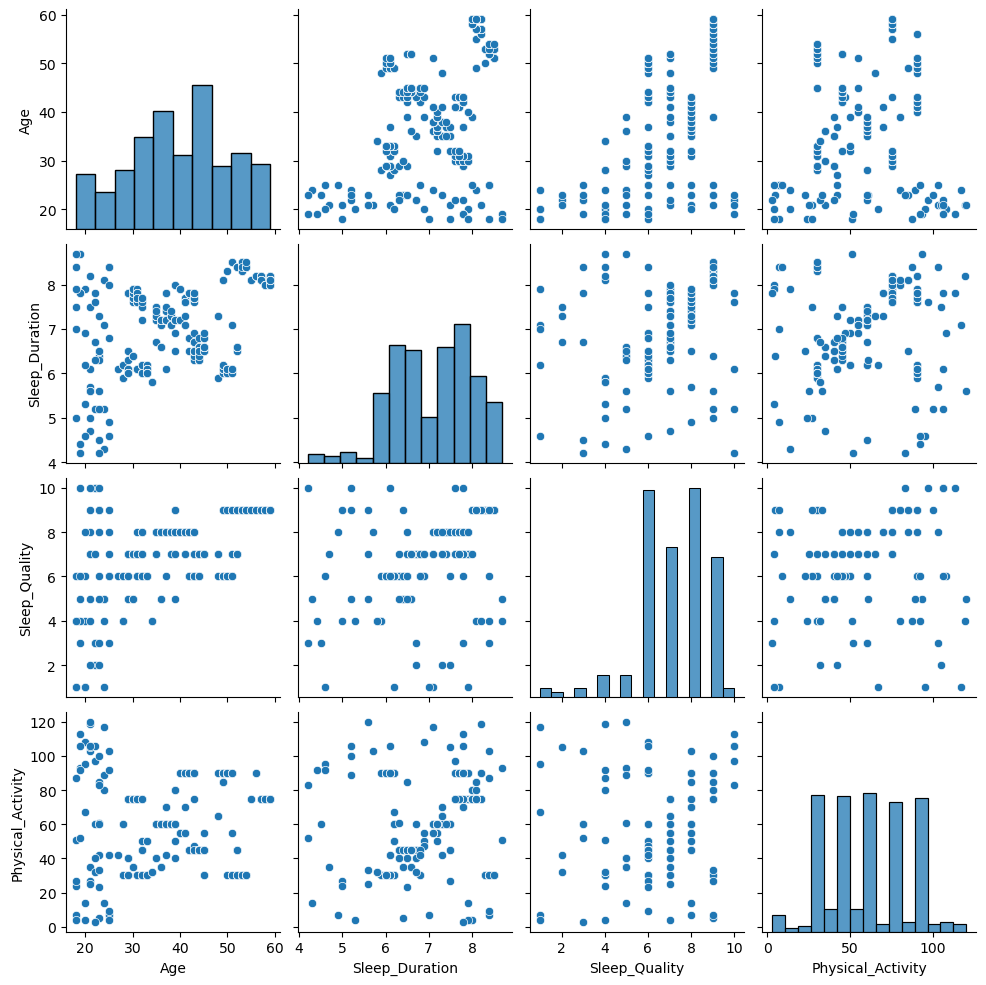

In [631]:
import seaborn as sns
sns.pairplot(merged_df)


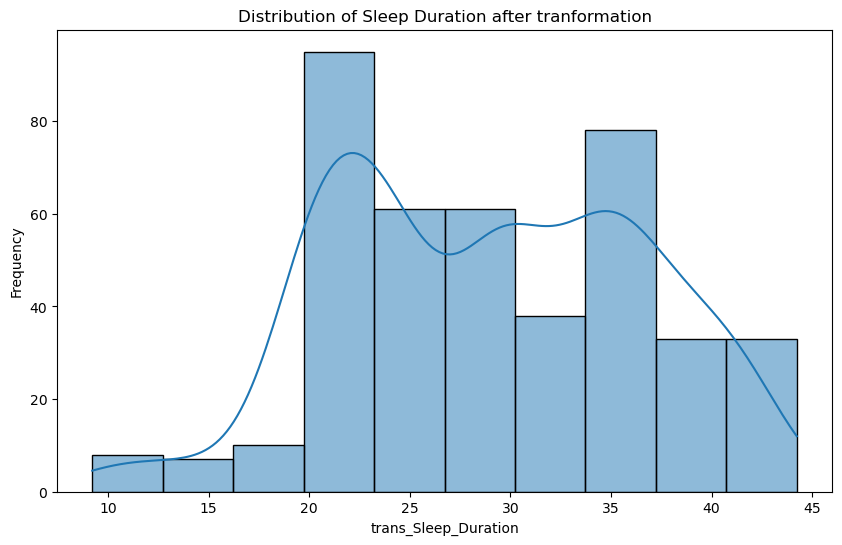

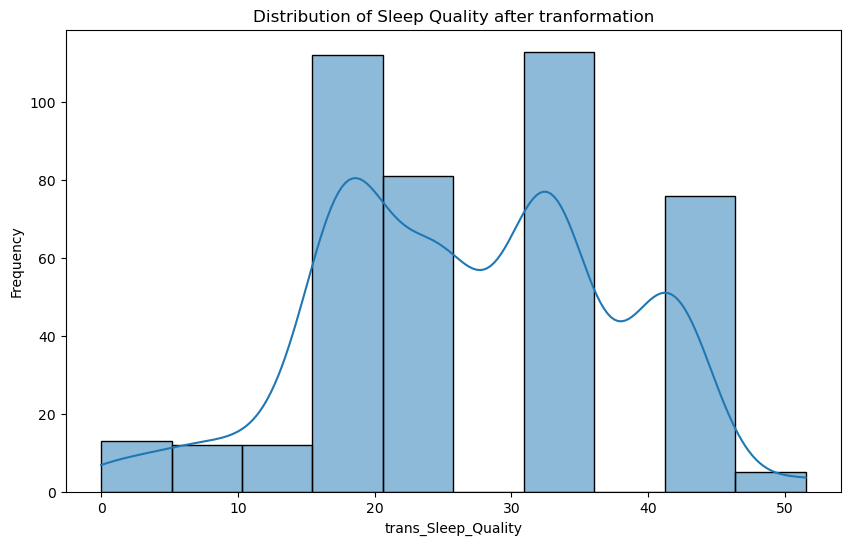

In [632]:
from scipy.stats import zscore

merged_df['trans_Sleep_Duration'], fitted_lambda = boxcox(merged_df['Sleep_Duration'] + 1e-6)
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['trans_Sleep_Duration'], bins=10, kde=True)
plt.title('Distribution of Sleep Duration after tranformation')
plt.ylabel('Frequency')
plt.show()

merged_df['trans_Sleep_Quality'], fitted_lambda = boxcox(merged_df['Sleep_Quality'] + 1e-6)
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['trans_Sleep_Quality'], bins=10, kde=True)
plt.title('Distribution of Sleep Quality after tranformation')
plt.ylabel('Frequency')
plt.show()



In [633]:
x = merged_df[['Age', 'trans_Sleep_Duration', 'Physical_Activity']]
y = merged_df['trans_Sleep_Quality']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nEvaluation Metrics:")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training R-squared: {train_r2}")
print(f"Testing R-squared: {test_r2}")


Evaluation Metrics:
Training RMSE: 7.8775140011887945
Testing RMSE: 7.2003018089221245
Training R-squared: 0.4497028664490583
Testing R-squared: 0.5016654075550788


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [634]:
x_vif = sm.add_constant(x)
vif_data = pd.DataFrame()
vif_data["Variable"] = x_vif.columns
vif_data["VIF"] = [variance_inflation_factor(x_vif.values, i) for i in range(x_vif.shape[1])]
print("\nVIF Analysis:\n", vif_data)


VIF Analysis:
                Variable        VIF
0                 const  25.400944
1                   Age   1.151394
2  trans_Sleep_Duration   1.159979
3     Physical_Activity   1.023074


In [635]:
x_ols = sm.add_constant(x)
ols_model = sm.OLS(y, x_ols).fit()
print("\nOLS Model Summary:\n", ols_model.summary())




OLS Model Summary:
                              OLS Regression Results                            
Dep. Variable:     trans_Sleep_Quality   R-squared:                       0.463
Model:                             OLS   Adj. R-squared:                  0.459
Method:                  Least Squares   F-statistic:                     120.7
Date:                 Tue, 03 Dec 2024   Prob (F-statistic):           2.21e-56
Time:                         22:45:32   Log-Likelihood:                -1469.6
No. Observations:                  424   AIC:                             2947.
Df Residuals:                      420   BIC:                             2963.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
c

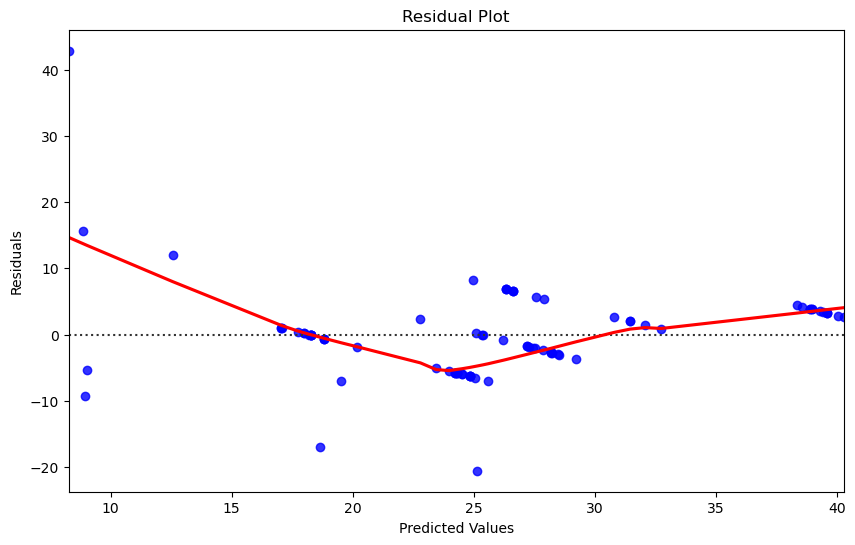

In [636]:
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test_pred, y=y_test - y_test_pred, lowess=True, color="blue", line_kws={"color": "red"})
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

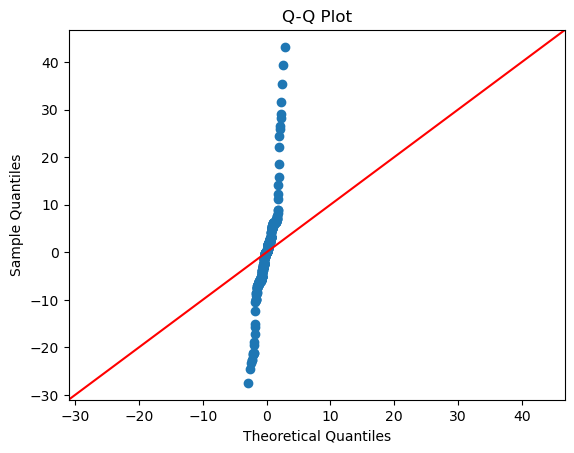

In [637]:
sm.qqplot(ols_model.resid, line='45')
plt.title('Q-Q Plot')
plt.show()

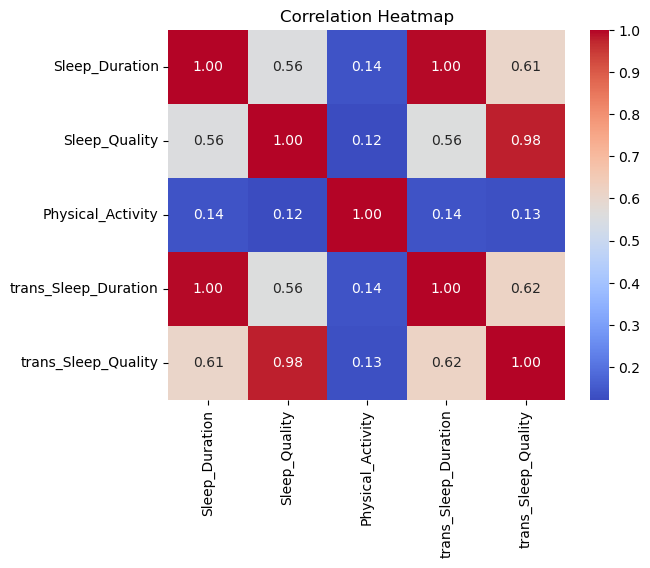

In [638]:
merged_df1 = merged_df.drop(columns=['Age'])
sns.heatmap(merged_df1.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


<Axes: >

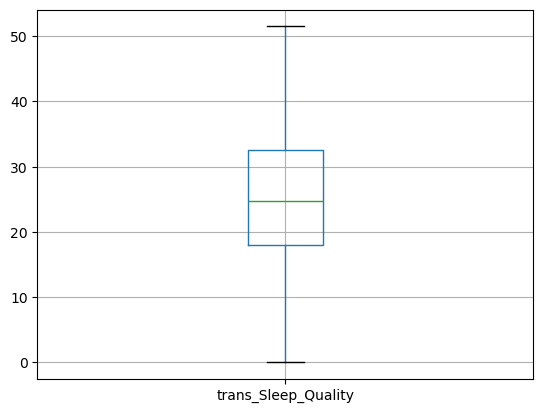

In [651]:
merged_df.boxplot(column=['trans_Sleep_Quality'])
